In [19]:
import os
import gzip
import struct
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering as HC
from sklearn.neural_network import BernoulliRBM
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
%matplotlib inline

# 1. MNIST

## 1.1 Load data

In [2]:
def read_gzfile(file_path):
    with gzip.open(file_path, 'rb') as f:
        return f.read()

In [3]:
def decode_idx3_ubyte(idx3_ubyte_file):
    if(idx3_ubyte_file.endswith(".gz")):
        bin_data = read_gzfile(idx3_ubyte_file)
    else:
        bin_data = open(idx3_ubyte_file,'rb').read()
    offest=0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offest)
    image_size = num_rows*num_cols
    offest += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offest)).reshape((num_rows, num_cols))
        offest += struct.calcsize(fmt_image)
    return images

def decode_idx1_ubyte(idx1_ubyte_file):
    if(idx1_ubyte_file.endswith(".gz")):
        bin_data = read_gzfile(idx1_ubyte_file)
    else:
        bin_data = open(idx1_ubyte_file,'rb').read()
    offest = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offest)
    offest += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        labels[i] = struct.unpack_from(fmt_image, bin_data, offest)[0]
        offest += struct.calcsize(fmt_image)
    return labels

In [4]:
def load_data(file_path):
    if("-idx3-ubyte" in file_path):
        return decode_idx3_ubyte(file_path)
    elif("-idx1-ubyte" in file_path):
        return decode_idx1_ubyte(file_path)

In [5]:
train_images = load_data("./data2forEx/train-images-idx3-ubyte.gz")
train_images = np.where(train_images.reshape(-1, train_images.shape[1]*train_images.shape[2])>0, 1, 0)
train_labels = load_data("./data2forEx/train-labels-idx1-ubyte.gz")

test_images = load_data("./data2forEx/t10k-images-idx3-ubyte.gz")
test_images = np.where(test_images.reshape(-1, test_images.shape[1]*test_images.shape[2])>0, 1, 0)
test_labels = load_data("./data2forEx/t10k-labels-idx1-ubyte.gz")

In [6]:
def calculateNPCs(explained_variance_ratio_, ratio=0):
    n_PCs = 0
    summary = 0
    for i, eigen_value in enumerate(explained_variance_ratio_):
        summary += eigen_value
        if(summary >= ratio):
            n_PCs = i
            break
    return n_PCs

In [7]:
def cluster_visualization(datas, clusters):
    labels = np.unique(clusters)
    colors = ["red", "green", "blue", "orange", "purple", "gold", "teal", "cyan", "thistle", "black"]
    tsne = TSNE(n_components=2, random_state=42)
    dots = tsne.fit_transform(datas)
    plt.figure(figsize=(10,10))
    for i, label in enumerate(labels):
        idx = np.where(clusters==label)[0]
        plt.plot(dots[idx,0], dots[idx,1], ".", color=colors[i], label=label)
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.legend()
    plt.show()

    
    #n_clusters = len(labels)
    #n_figures = 5
    #plt.figure(figsize=(5*n_figures, 5*n_clusters))
    #i = 0
    #for j, label in enumerate(labels):
    #    idxs = np.where(clusters==label)[0][:n_figures]
    #    for k, idx in enumerate(idxs):
    #        print(clusters[idx], end=", ")
    #        i += 1
    #    print()
    #plt.show()

## 使用RBM进行降维，对比PCA

In [8]:
pca = PCA()
pca.fit(train_images)
n_PCs = calculateNPCs(pca.explained_variance_ratio_, ratio=0.95)
print("选择占比超过95%%的n_Pc = %d"%(n_PCs))

选择占比超过95%的n_Pc = 265


In [9]:
pca = PCA(n_components = n_PCs)
train_images_pca = pca.fit_transform(train_images)
test_images_pca = pca.transform(test_images)

In [10]:
rbm = BernoulliRBM(n_components=100)

In [11]:
rbm.fit(train_images)

BernoulliRBM(n_components=100)

In [12]:
train_images_rbm = rbm.transform(train_images)
test_images_rbm = rbm.transform(test_images)

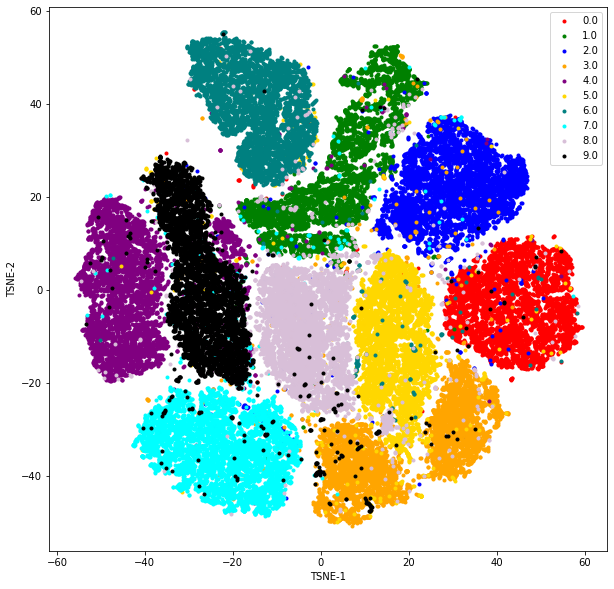

In [15]:
cluster_visualization(train_images_pca, train_labels)

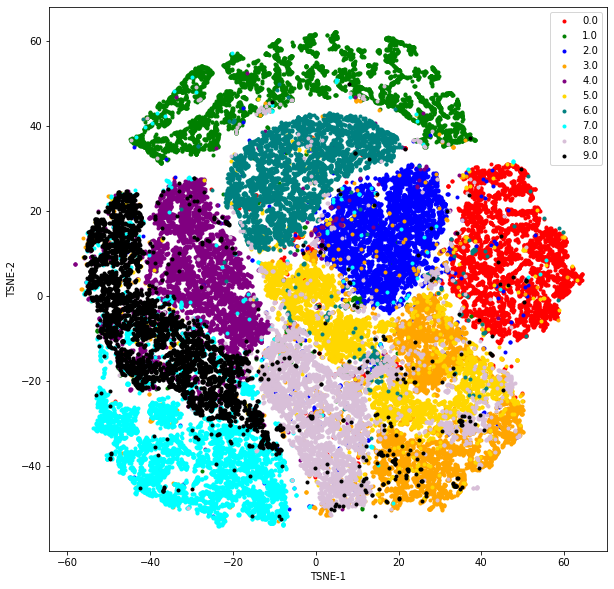

In [16]:
cluster_visualization(train_images_rbm, train_labels)

## 使用logistic分类器进行预测

### RBM降维预测结果

In [37]:
logi1 = LogisticRegression(max_iter=1000)
logi1.fit(train_images_rbm, train_labels)

LogisticRegression(max_iter=1000)

In [38]:
logi1.score(train_images_rbm, train_labels)

0.9250833333333334

In [39]:
logi1.score(test_images_rbm, test_labels)

0.9242

### 不降维预测结果

In [40]:
logi2 = LogisticRegression(random_state=1, max_iter=1000)
logi2.fit(train_images, train_labels)

/home/thu-cyf/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=1)

In [41]:
logi2.score(train_images, train_labels)

0.9336833333333333

In [42]:
logi2.score(test_images, test_labels)

0.918

### PCA降维预测结果

In [43]:
logi3 = LogisticRegression(random_state=1, max_iter=1000)
logi3.fit(train_images_pca, train_labels)

LogisticRegression(max_iter=1000, random_state=1)

In [44]:
logi3.score(train_images_pca, train_labels)

0.9249166666666667

In [46]:
logi3.score(test_images_pca, test_labels)

0.9197

## 特征查看

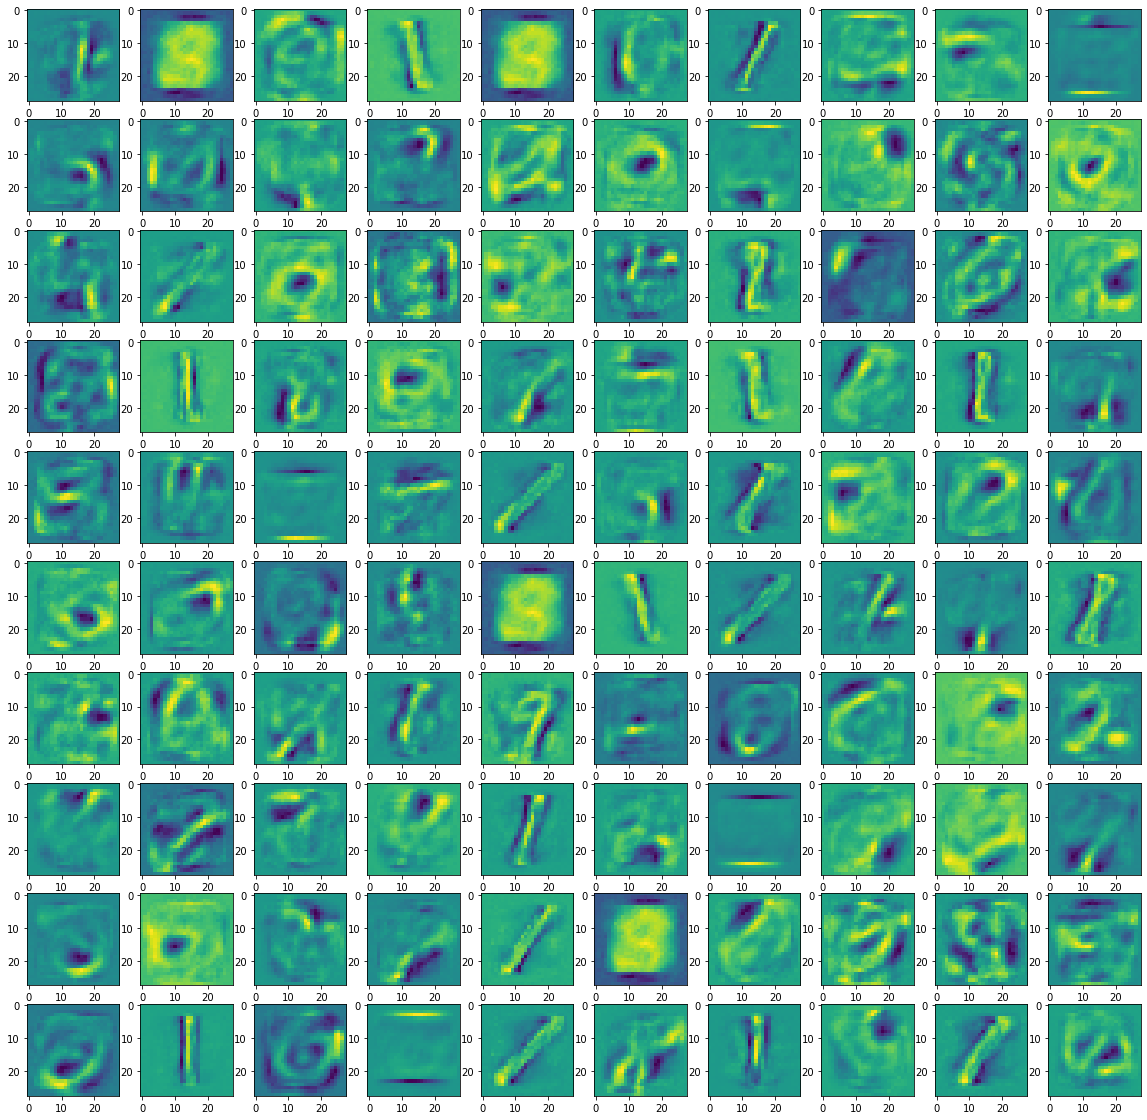

In [58]:
plt.figure(figsize=(20,20))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10,10,i+1)
    plt.imshow((comp).reshape(28,28))
plt.show()